# Runthrough

### Introduction

We want to know whether men spend more than women on Black Friday at Walmart...

Let's start by loading and viewing the dataset:

In [12]:
# Import appropriate libraries
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Load the data as a dataframe from the csv file
df = pd.read_csv('./walmart_data.csv')

# Make all column names lowercase for sanity
df.columns = [c.lower() for c in df.columns]

# Display the first 5 rows of data to get an idea of what we're working with
df.head()

,user_id,product_id,gender,age,occupation,city_category,stay_in_current_city_years,marital_status,product_category,purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,7969


We can do some initial exploration to learn about the spending of men and women

First let's look at what the total purchase amounts and products bought were for men and women:

In [35]:
print('\nSum total of purchase (dollar) amounts: ')
print(df.groupby(['gender'])['purchase'].sum())

print('\nTotal number of different products purchased: ')
print(df.groupby(['gender'])['product_id'].nunique())

print('\nTotal number of transactions: ')
print(df.groupby(['gender'])['purchase'].count())

print('\nNumber of men and women in the data: ')
print(df.groupby(['gender'])['user_id'].nunique())


Sum total of purchase (dollar) amounts: 
gender
F    1186232642
M    3909580100
Name: purchase, dtype: int64

Total number of different products purchased: 
gender
F    3367
M    3588
Name: product_id, dtype: int64

Total number of transactions: 
gender
F    135809
M    414259
Name: purchase, dtype: int64

Number of men and women in the data: 
gender
F    1666
M    4225
Name: user_id, dtype: int64


As we can see, men clearly spent more money, bought a larger number of different products, and had more separate transactions than women

There are over two and a half times as many men as there are women, so it makes sense that they are accounting for so many more purchases

We want to normalize these results to control for the population difference between men and women

We have two options to divide by:
- The number of individual transactions for each gender

    - This will give us an idea of what each gender is contributing to the total purchase amount


- The number of unique users for each gender

    - This will give us an idea of the average spending patterns per user, what each individual is likely to do based on gender
    
We will be using these metrics for many future normalizations, so let's define them now and then normalize our previous numbers:

In [37]:
num_transactions = df.groupby(['gender'])['purchase'].count()

num_users = df.groupby(['gender'])['user_id'].nunique()

In [38]:
print('\nNormalized (per transaction) sum total of purchase (dollar) amounts: ')
print(df.groupby('gender')['purchase'].sum() / num_transactions)

print('\nNormalized (per transaction) total number of different products purchased: ')
print(df.groupby('gender')['product_id'].nunique() / num_transactions)


Normalized (per transaction) sum total of purchase (dollar) amounts: 
gender
F    8734.565765
M    9437.526040
Name: purchase, dtype: float64

Normalized (per transaction) total number of different products purchased: 
gender
F    0.024792
M    0.008661
dtype: float64


In [39]:
print('\nNormalized (per user) sum total of purchase (dollar) amounts: ')
print(df.groupby('gender')['purchase'].sum() / num_users)

print('\nNormalized (per user) total number of different products purchased: ')
print(df.groupby('gender')['product_id'].nunique() / num_users)

print('\nNormalized (per user) total number of transactions: ')
print(df.groupby('gender')['purchase'].count() / num_users)


Normalized (per user) sum total of purchase (dollar) amounts: 
gender
F    712024.394958
M    925344.402367
dtype: float64

Normalized (per user) total number of different products purchased: 
gender
F    2.021008
M    0.849231
dtype: float64

Normalized (per user) total number of transactions: 
gender
F    81.518007
M    98.049467
dtype: float64


<AxesSubplot:>

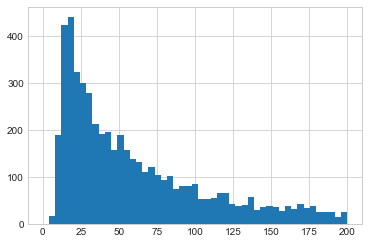

In [26]:
# Look at the number of products bought by users
# Group the data by the user_id and count the number of product_ids each of them have
df.groupby(['user_id'])['product_id'].count().hist(bins=np.linspace(0, 200, 50))

Here we see that most users buy around 20 products with no visible outliers

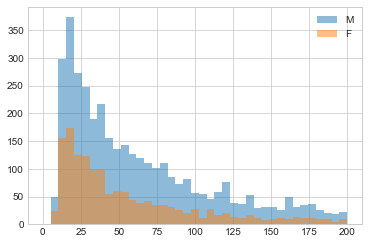

In [14]:
# Next we want to compare these purchase amounts between men and women
# Group the data by user_id and gender and add their respective product_id counts
df.groupby(['user_id', 'gender'])['product_id'].count().unstack().pipe(
    lambda d: (
        d['M'].dropna().hist(bins=np.linspace(0, 200, 40), alpha=0.5, label='M'),
        d['F'].dropna().hist(bins=np.linspace(0, 200, 40), alpha=0.5, label='F')
    )
)
plt.legend()

Here we can see that the distributions seem comparable between men and women with the men accounting for many more sales

Let's check the what it looks like when normalized

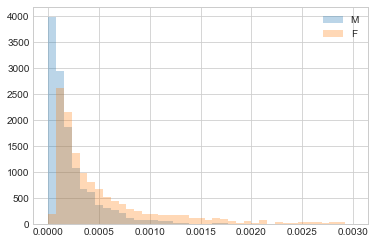

In [16]:
# Divide by the number of transactions per gender to see overall contributions
df.groupby(['user_id', 'gender'])['product_id'].count().unstack().pipe(
    lambda d: (
        (d['M'] / d['M'].sum()).dropna().hist(bins=np.linspace(0, 0.003, 40), alpha=0.3, label='M', density=True),
        (d['F'] / d['F'].sum()).dropna().hist(bins=np.linspace(0, 0.003, 40), alpha=0.3, label='F', density=True)
    )
)
plt.legend()

Here is looks like many more men have a very small number of purchases but more women consistently have more purchases than men, so they might even out 

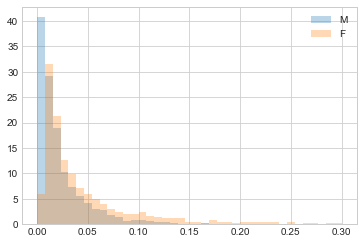

In [17]:
# Divide by the number of users per gender to see individual stats
df.groupby(['user_id', 'gender'])['product_id'].count().unstack().pipe(
    lambda d: (
        (d['M'] / len(d['M'].dropna())).dropna().hist(bins=np.linspace(0, 0.3, 40), alpha=0.3, label='M', density=True),
        (d['F'] / len(d['F'].dropna())).dropna().hist(bins=np.linspace(0, 0.3, 40), alpha=0.3, label='F', density=True)
    )
)
plt.legend()

A similar result can be seen here

- Sidenote: need to find out what exactly default=True does and do we even need to divide to normalize or can we just use that? Because something very interesting happens when it's used on the original unnormalized graph:

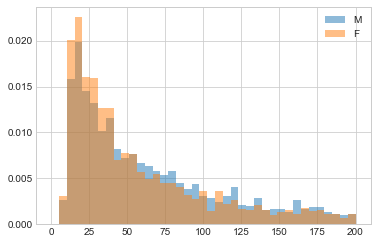

In [18]:
df.groupby(['user_id', 'gender'])['product_id'].count().unstack().pipe(
    lambda d: (
        d['M'].dropna().hist(bins=np.linspace(0, 200, 40), alpha=0.5, label='M', density=True),
        d['F'].dropna().hist(bins=np.linspace(0, 200, 40), alpha=0.5, label='F', density=True)
    )
)
plt.legend()

Let's generate some heat maps to understand which products men and women are more likely to buy

First raw numbers:

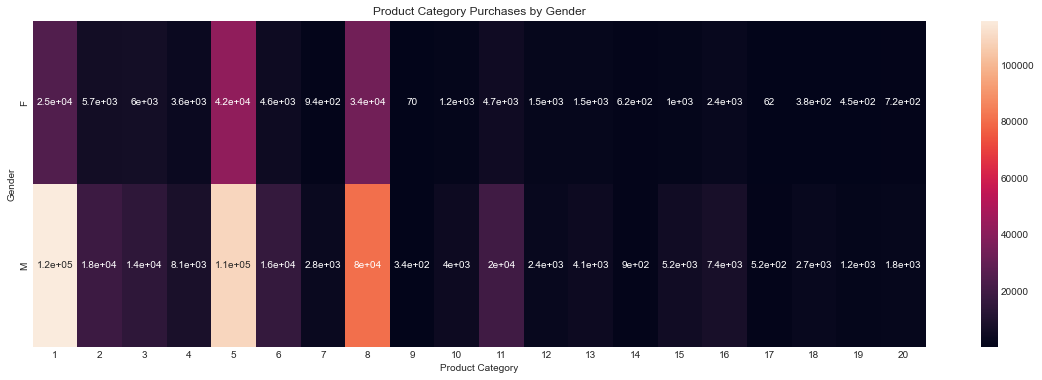

In [19]:
category_gender_counts = df.groupby(['gender', 'product_category'])['purchase'].count().unstack().fillna(0)

# Plot the heatmap
plt.figure(figsize=(20, 6))
sns.heatmap(category_gender_counts, annot=True, cbar=True)

# Add labels and title
plt.title("Product Category Purchases by Gender")
plt.xlabel("Product Category")
plt.ylabel("Gender")
plt.show()

Now normalized:

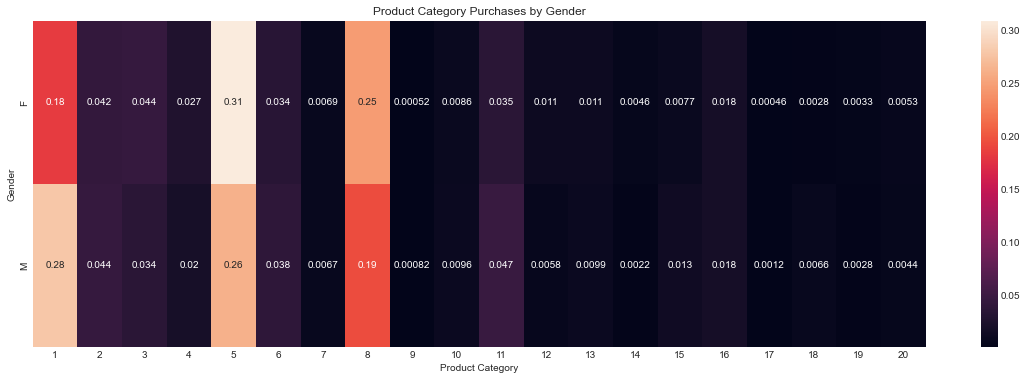

In [20]:
category_gender_counts = category_gender_counts.div(category_gender_counts.sum(axis=1), axis=0)

# Plot the heatmap
plt.figure(figsize=(20, 6))
sns.heatmap(category_gender_counts, annot=True, cbar=True)

# Add labels and title
plt.title("Product Category Purchases by Gender")
plt.xlabel("Product Category")
plt.ylabel("Gender")
plt.show()

Product categories 1, 5, and 8 are definitely standouts

It looks like men have more purchases in category 1 and women in 5 and 8

We can also look at bar graphs of how much was spent in each category:

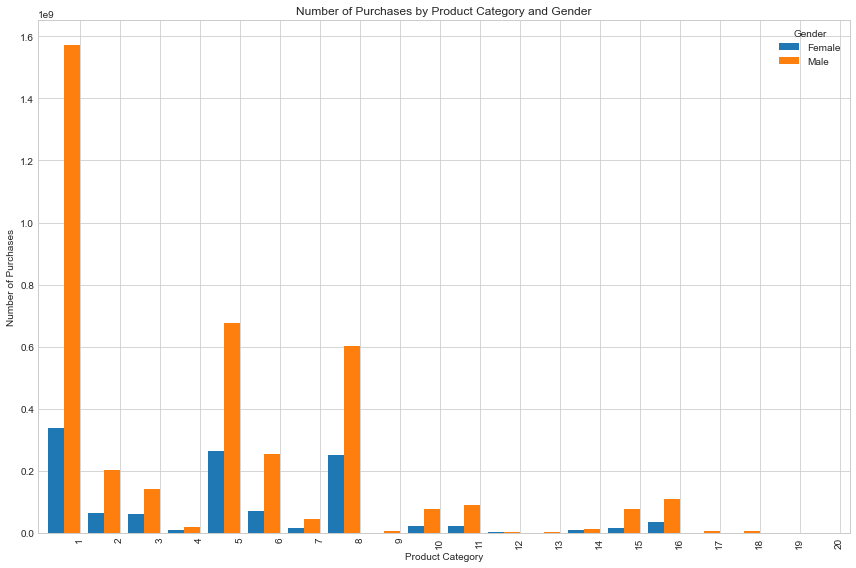

In [21]:
# Group by gender and product_id to count the number of purchases
purchase_counts = df.groupby(['gender', 'product_category'])['purchase'].sum().unstack().fillna(0)

# Plotting a grouped bar chart
purchase_counts.T.plot(kind='bar', figsize=(12, 8), width=0.8, position=1)

# Adding labels and title
plt.title("Number of Purchases by Product Category and Gender")
plt.xlabel("Product Category")
plt.ylabel("Number of Purchases")
plt.xticks(rotation=90)
plt.legend(title="Gender", labels=["Female", "Male"])
plt.tight_layout()

# Show the plot
plt.show()

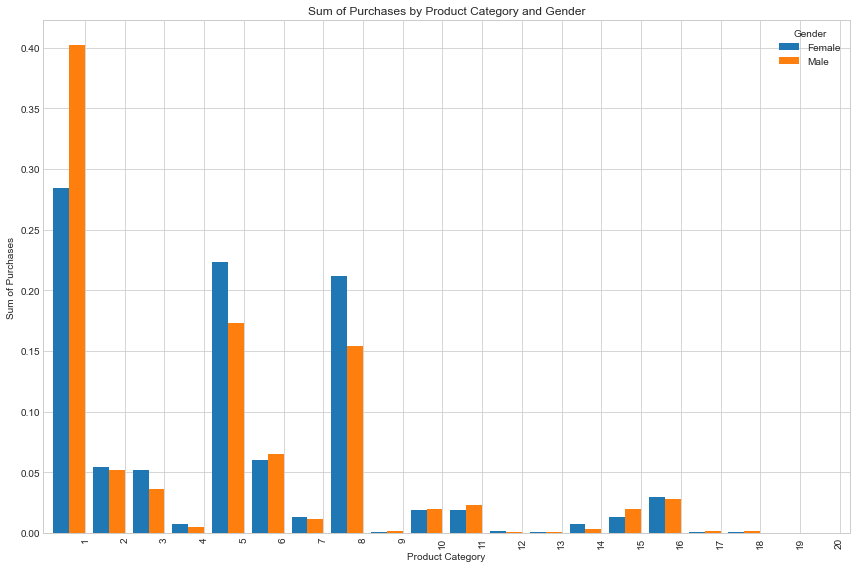

In [22]:
# Normalized

# Group by gender and product_id to count the number of purchases
purchase_amounts = df.groupby(['gender', 'product_category'])['purchase'].sum().unstack().fillna(0)
# Normalize
purchase_amounts_normalized = purchase_amounts.div(purchase_amounts.sum(axis=1), axis=0)

# Plotting a grouped bar chart
purchase_amounts_normalized.T.plot(kind='bar', figsize=(12, 8), width=0.8, position=1)

# Adding labels and title
plt.title("Sum of Purchases by Product Category and Gender")
plt.xlabel("Product Category")
plt.ylabel("Sum of Purchases")
plt.xticks(rotation=90)
plt.legend(title="Gender", labels=["Female", "Male"])
plt.tight_layout()

# Show the plot
plt.show()